In [1]:
# NETS = ['dilation', 'crossing', 'multi_lstm_init','lstm', 'unet']
import tensorflow as tf
import datasets
import pickle
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import itertools
import seaborn as sns


        

        id: 0,
        name: DATA_C0_D0,
        dataset_path: ,
        num_images_training: 10.0,
        num_images_testing: 10000.0,
        complexity: 0,
        

        

        id: 1,
        name: DATA_C0_D0,
        dataset_path: ,
        num_images_training: 10.0,
        num_images_testing: 10000.0,
        complexity: 0,
        

        

        id: 2,
        name: DATA_C1_D0,
        dataset_path: ,
        num_images_training: 10.0,
        num_images_testing: 10000.0,
        complexity: 1,
        

        

        id: 3,
        name: DATA_C1_D0,
        dataset_path: ,
        num_images_training: 10.0,
        num_images_testing: 10000.0,
        complexity: 1,
        

        

        id: 4,
        name: DATA_C2_D0,
        dataset_path: ,
        num_images_training: 10.0,
        num_images_testing: 10000.0,
        complexity: 2,
        

        

        id: 5,
        name: DATA_C2_D0,
        dataset_path: ,
        num_images_train

In [2]:


results_data = []
for NET in NETS:
    if NET == 'dilation':
        import experiments.dilation as experiments
    elif NET == 'segnet':
        import experiments.segnet as experiments
    elif NET == 'lstm':
        import experiments.lstm as experiments
    elif NET == 'coloring':
        import experiments.coloring as experiments
    elif NET == 'crossing':
        import experiments.crossing as experiments
    elif NET == 'unet':
        import experiments.unet as experiments
    elif NET == 'multi_lstm':
        import experiments.multi_lstm as experiments
    elif NET == 'multi_lstm_init':
        import experiments.multi_lstm_init as experiments
    elif NET == 'FF':
        import experiments.FF as experiments
    elif NET == 'optimal_lstm':
        import experiments.optimal_lstm as experiments

    output_path = '/om/user/xboix/share/insideness/' + NET + '/'
    run_opt = experiments.get_experiments(output_path)[1:]
    print(len(run_opt))

    results_data.append([])
    for opt in run_opt:
        if not opt.skip:
            data_point = {}
            
            if opt.dataset.complexity>4:
                continue
            if NET == 'multi_lstm_init':
                opt.dataset.complexity_strict = True
                
            if opt.dataset.complexity_strict == False:
                continue
                
            data_point["dataset_complexity"] = opt.dataset.complexity
            data_point["dataset_strict_complexity"] = opt.dataset.complexity_strict
            if opt.dataset.image_size == 80:
                data_point["dataset_complexity"] = 6 

            if not os.path.isfile(opt.log_dir_base + opt.name + '/results/intra_dataset_accuracy.pkl'):
                data_point["results"] = "empty"

            else:
                with open(opt.log_dir_base + opt.name + '/results/intra_dataset_accuracy.pkl', 'rb') as f:
                    data_point["results"] = pickle.load(f)

            results_data[-1].append(copy.deepcopy(data_point))

NameError: name 'NETS' is not defined

In [3]:
# NUM_COMPLEXITIES = 5
NUM_COMPLEXITIES = 6

max_train = []
max_test = []
max_train_loose = []
max_test_loose = []
for idx_net, NET in enumerate(NETS):
    
    max_val_acc = -np.ones([2, NUM_COMPLEXITIES])
    max_idx = np.zeros([2, NUM_COMPLEXITIES])
    missing = np.zeros([2, NUM_COMPLEXITIES])
    
    for point_idx, data_point in enumerate(results_data[idx_net]):

        point_complextity = data_point["dataset_complexity"]
        idx_strict = 1-int(data_point["dataset_strict_complexity"])

        #if (not ("val" in data_point["results"])):
        #    print(point_idx)

        if not (data_point["results"] == "empty") and ("val" in data_point["results"]): 

                if max_val_acc[idx_strict, point_complextity] < data_point["results"]["valloose"]:
                    max_idx[idx_strict, point_complextity] = point_idx
                    max_val_acc[idx_strict, point_complextity] = data_point["results"]["valloose"]

        else:
            missing[idx_strict, point_complextity] += 1
    print(max_idx)
    
    max_train.append(np.zeros([2, NUM_COMPLEXITIES]))
    max_test.append(np.zeros([2, NUM_COMPLEXITIES]))
    max_train_loose.append(np.zeros([2, NUM_COMPLEXITIES]))
    max_test_loose.append(np.zeros([2, NUM_COMPLEXITIES]))


    for idx_strict, dataset_strict_complexity  in enumerate([True, False]):
        for dataset_complexity in range(NUM_COMPLEXITIES):
            #if  results_data[int(max_idx[idx_strict,dataset_complexity])]["results"]=="empty":
            #    continue
            max_train[-1][idx_strict, dataset_complexity] = \
                results_data[idx_net][int(max_idx[idx_strict,dataset_complexity])]["results"]["train"]
            max_test[-1][idx_strict, dataset_complexity] = \
                results_data[idx_net][int(max_idx[idx_strict,dataset_complexity])]["results"]["test"]
            max_train_loose[-1][idx_strict, dataset_complexity] = \
                results_data[idx_net][int(max_idx[idx_strict,dataset_complexity])]["results"]["trainloose"]
            max_test_loose[-1][idx_strict, dataset_complexity] = \
                results_data[idx_net][int(max_idx[idx_strict,dataset_complexity])]["results"]["testloose"]

            
        

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


TypeError: string indices must be integers

{'result': array([[0.03125   , 0.00179712, 0.02046725],
       [0.08156949, 0.05870607, 0.29113419],
       [0.93560304, 0.41503594, 0.62729633],
       [0.99770367, 0.35752796, 0.96615415],
       [0.9990016 , 0.88089058, 0.9774361 ],
       [0.99790335, 0.65924521, 0.98921725],
       [0.97454073, 0.33985623, 0.32138578]]), 'parameters': array([[30., 30., 30.],
       [10., 30.,  5.],
       [10., 10., 10.],
       [30., 30., 30.],
       [30., 10., 30.],
       [30., 30., 30.],
       [30., 30., 30.]])}
{'result': array([[0.24810304, 0.45087859, 0.24990016],
       [0.92641773, 0.70027955, 1.        ],
       [0.96535543, 0.90295527, 1.        ],
       [0.9918131 , 0.93150958, 1.        ],
       [0.97484026, 0.85013978, 1.        ],
       [0.84784345, 0.53244808, 0.27735623],
       [0.05351438, 0.        , 0.03694089]]), 'parameters': array([[ 5.,  5.,  5.],
       [10.,  5.,  5.],
       [ 5.,  5.,  5.],
       [ 5.,  5.,  5.],
       [30., 10., 10.],
       [60., 30., 60.],
  

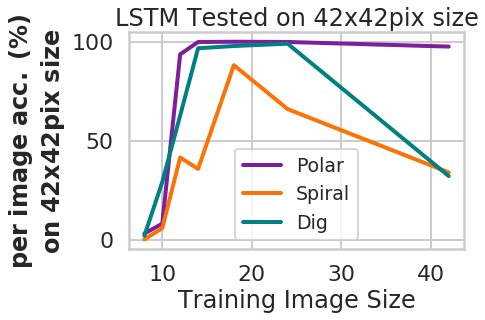

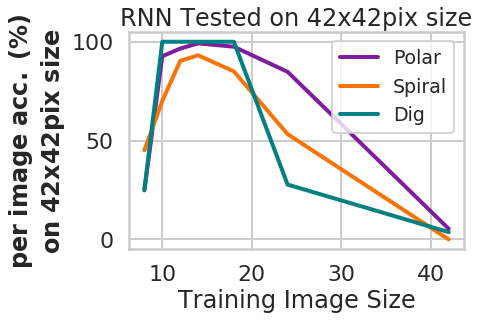

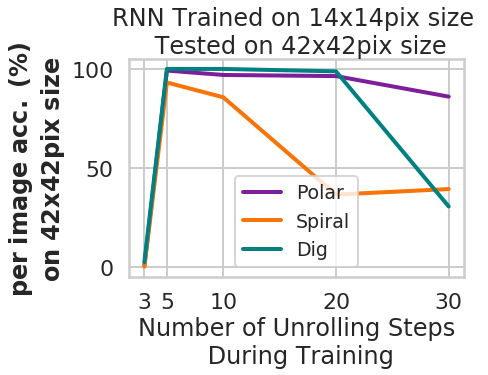

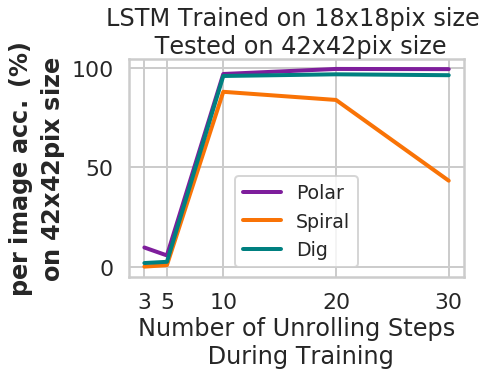

In [13]:
import seaborn
import pickle
import numpy as np
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple


seaborn.set()
seaborn.set_style("whitegrid")
seaborn.set_context("poster")

with open("multi_lstm_init_final_results.pkl", "rb") as f:
    accuracies = pickle.load(f)
    print(accuracies)
    
with open("rnn_final_results.pkl", "rb") as f:
    accuracies2 = pickle.load(f)
    print(accuracies2)

with open("lstm_iteration_results.pkl", "rb") as f:
    iterations = pickle.load(f)
    print(iterations)
    
with open("rnn_iteration_results.pkl", "rb") as f:
    iterations2 = pickle.load(f)
    print(iterations2)

results1 = accuracies['result']*100
results2 = accuracies2['result']*100

def plot_small_image_results(results, xticks,main_title, title, fig, name,colors):
    
#     hb = mlines.Line2D([], [], marker='None', linestyle='None')

    x = np.linspace(1,5, 7)
    #x-axis = training image size
    # y-axis = testing in 42x42
    #Dotted line indicating accuracy for training in 42x42
    #3 lines - polar, spiral, digs
    xlabels = ['8','10','12','14','18', '24', '42' ]
    ytext =r'$\bf per$ $\bf image$ $\bf acc.$ $\bf(\%)$' + '\n' + r'$\bf on $'+ ' ' +  r'$\bf 42x42pix$' + ' ' + r'$\bf size$'

    figure, ax = plt.subplots()
#     figure.set_figheight(5)
#     figure.set_figwidth(8)
    lines = []
    for i in range(3):
        line1, = plt.plot(xticks, results[:,i], colors[i], linewidth=4)
        lines.append(line1)
#     lines.append(hb)
#     for i in range(3):
#         line2, = plt.plot([8, 10, 12, 14, 18, 24, 42], results2[:,i], colors[i], linewidth=4, linestyle='--')
#         lines.append(line2)

    
    lines = tuple(lines)
    plt.ylabel(ytext)
    plt.xlabel('Training Image Size')
    plt.title(main_title)
#     plt.xticks(x, xlabels)
    ax.set_xticks([10, 20, 30, 40])
    if title == "rnn_results":
        leg = plt.legend(lines, ("Polar", "Spiral", "Dig"), loc='upper right', ncol=1,  fancybox=True, prop={'size': 19})
    else:
        leg = plt.legend(lines, ("Polar", "Spiral", "Dig"), loc='lower center', ncol=1,  fancybox=True, prop={'size': 19})
    plt.savefig('figures/{}.pdf'.format(title), format='pdf',  bbox_inches='tight', dpi=1000)

def plot_iteration_results(results, xticks, main_title, title, fig, name,colors):
    
    ha = mlines.Line2D([], [], marker='None', linestyle='None')
#     hb = mlines.Line2D([], [], marker='None', linestyle='None')

    x = np.linspace(1,5, 7)
    xlabels = ['8','10','12','14','18', '24', '42' ]
    ytext =r'$\bf per$ $\bf image$ $\bf acc.$ $\bf(\%)$' + '\n' + r'$\bf on $'+ ' ' +  r'$\bf 42x42pix$' + ' ' + r'$\bf size$'

    figure, ax = plt.subplots()

    lines = []
    for i in range(3):
        line1, = plt.plot(xticks, results[:,i], colors[i], linewidth=4)
        lines.append(line1)
#     lines.append(hb)
#     for i in range(3):
#         line2, = plt.plot([8, 10, 12, 14, 18, 24, 42], results2[:,i], colors[i], linewidth=4, linestyle='--')
#         lines.append(line2)

    
    lines = tuple(lines)
    plt.ylabel(ytext)
    plt.xlabel('Number of Unrolling Steps\n During Training')
    plt.title(main_title)
#     plt.xticks(x, xlabels)
    ax.set_xticks(xticks)
    if title == "rnn_iterations":
        leg = plt.legend(lines, ("Polar", "Spiral", "Dig"), loc='best', ncol=1,  fancybox=True, prop={'size': 19})
    else:
        leg = plt.legend(lines, ("Polar", "Spiral", "Dig"), loc='lower center', ncol=1,  fancybox=True, prop={'size': 19})
    plt.savefig('figures/{}.pdf'.format(title), format='pdf',  bbox_inches='tight', dpi=1000)

def plot_results_train_test_image(train, title, fig, name,c):

    x = np.linspace(1,5, NUM_COMPLEXITIES)
    xlabels = ['4','9','14','19','24' ]
    ytext =r'$\bf per$ $\bf image$ $\bf acc.$ $\bf(\%)$'

    plt.figure(fig)
    print(train)
    plt.plot(x, train, c,label=name, linewidth=4)
    plt.ylabel(ytext)
    plt.xlabel('Polar Dataset')
    plt.title('Test Acc. on Polar')
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='lower center', ncol=1,  fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/2.pdf', format='pdf',  bbox_inches='tight', dpi=1000)
colors = ('xkcd:purple', 'xkcd:orange', 'teal')
plot_small_image_results(results1, [8, 10, 12, 14, 18, 24, 42], "LSTM Tested on 42x42pix size", "lstm_results", 2, ('Polar', 'Spiral', 'Dig'), colors)
plot_small_image_results(results2, [8, 10, 12, 14, 18, 24, 42], "RNN Tested on 42x42pix size", "rnn_results", 2, ('Polar', 'Spiral', 'Dig'), colors)
plot_iteration_results(iterations2['accuracy']*100, [3, 5, 10, 20, 30], "RNN Trained on 14x14pix size \n Tested on 42x42pix size", "rnn_iterations", 2, ('Polar', 'Spiral', 'Dig'), colors)
plot_iteration_results(iterations['accuracy']*100, [3, 5, 10, 20, 30], "LSTM Trained on 18x18pix size \n Tested on 42x42pix size", "lstm_iterations", 2, ('Polar', 'Spiral', 'Dig'), colors)

# plot_results_train_test_image(100*max_test[0][0,:], "Exclusive Complexity", 1, 'Dilated', 'g')
# plot_results_train_test_image(100*max_test[1][0,:], "Exclusive Complexity", 1, 'Ray-int.', 'g--')
# plot_results_train_test_image(100*max_test[4][0,:], "Exclusive Complexity", 1, 'UNet', 'r')
# plot_results_train_test_image(100*max_test[2][0,:], "Exclusive Complexity", 1, '2-LSTM', 'b')
# plot_results_train_test_image(100*max_test[3][0,:], "Exclusive Complexity", 1, '1-LSTM', 'b--')


# plot_results_train_test(100*max_test_loose[0][0,:], "Loose Acc - Exclusive Complexity", 2, 'Dilated', 'g')
# plot_results_train_test(100*max_test_loose[1][0,:], "Loose Acc - Exclusive Complexity", 2, 'Ray-int.','g--')
# plot_results_train_test(100*max_test_loose[4][0,:], "Exclusive Complexity", 2, 'UNet','r')
# plot_results_train_test(100*max_test_loose[2][0,:], "Exclusive Complexity", 2, '2-LSTM', 'b')
# plot_results_train_test(100*max_test_loose[3][0,:], "Exclusive Complexity", 2, '1-LSTM', 'b--')




[100.         100.          99.96421354  99.9705288   99.80422701]
[6.70638262e+01 9.92337487e+01 5.85224402e+01 8.42034355e-03
 2.52610307e-02]
[100.          99.99894746  99.99264953  99.96105591 100.        ]
[100.          99.97684406  99.98000168  99.95263557  99.89895588]
[99.96954805 97.06445773 94.03523914 91.30704783 66.99953797]
[100.         100.          99.99997857  99.99998398  99.99987511]
[99.87519232 99.98849444 99.48395417 94.94189434 94.39905908]
[100.          99.99999936  99.9999954   99.99997713 100.        ]
[100.          99.99998564  99.99998746  99.99996796  99.99991415]
[99.99995442 99.99707342 99.99364081 99.98916514 99.9347826 ]


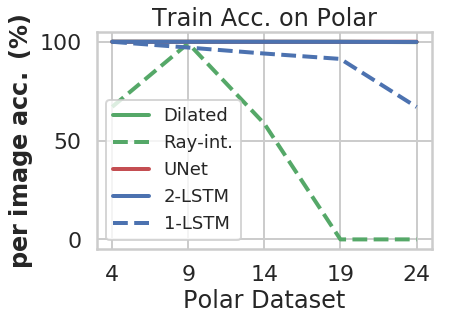

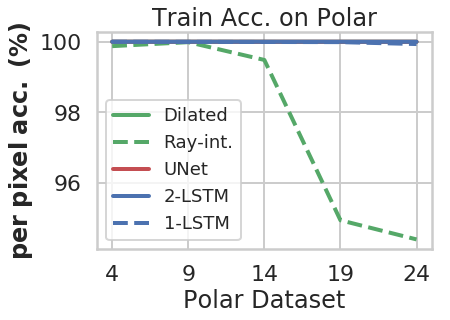

In [5]:
import seaborn

seaborn.set()
seaborn.set_style("whitegrid")
seaborn.set_context("poster")
def plot_results_train_test(train, title, fig, name,c):

    x = np.linspace(1,5, NUM_COMPLEXITIES)
    xlabels = ['4','9','14','19','24' ]
    ytext =r'$\bf per$ $\bf pixel$ $\bf acc.$ $\bf(\%)$'

    plt.figure(fig)
    print(train)
    plt.plot(x, train, c,label=name, linewidth=4)
    plt.ylabel(ytext)
    plt.xlabel('Polar Dataset')
    plt.title('Train Acc. on Polar')
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='lower left', ncol=1,  fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/train_1.pdf', format='pdf',  bbox_inches='tight', dpi=1000)

def plot_results_train_test_image(train, title, fig, name,c):

    x = np.linspace(1,5, NUM_COMPLEXITIES)
    xlabels = ['4','9','14','19','24' ]
    ytext =r'$\bf per$ $\bf image$ $\bf acc.$ $\bf(\%)$'

    plt.figure(fig)
    print(train)
    plt.plot(x, train, c,label=name, linewidth=4)
    plt.ylabel(ytext)
    plt.xlabel('Polar Dataset')
    plt.title('Train Acc. on Polar')
    plt.xticks(x, xlabels)
    leg = plt.legend(loc='lower left', ncol=1,  fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/train_2.pdf', format='pdf',  bbox_inches='tight', dpi=1000)

plot_results_train_test_image(100*max_train[0][0,:], "Exclusive Complexity", 1, 'Dilated', 'g')
plot_results_train_test_image(100*max_train[1][0,:], "Exclusive Complexity", 1, 'Ray-int.', 'g--')
plot_results_train_test_image(100*max_train[4][0,:], "Exclusive Complexity", 1, 'UNet', 'r')
plot_results_train_test_image(100*max_train[2][0,:], "Exclusive Complexity", 1, '2-LSTM', 'b')
plot_results_train_test_image(100*max_train[3][0,:], "Exclusive Complexity", 1, '1-LSTM', 'b--')


plot_results_train_test(100*max_train_loose[0][0,:], "Loose Acc - Exclusive Complexity", 2, 'Dilated', 'g')
plot_results_train_test(100*max_train_loose[1][0,:], "Loose Acc - Exclusive Complexity", 2, 'Ray-int.','g--')
plot_results_train_test(100*max_train_loose[4][0,:], "Exclusive Complexity", 2, 'UNet','r')
plot_results_train_test(100*max_train_loose[2][0,:], "Exclusive Complexity", 2, '2-LSTM', 'b')
plot_results_train_test(100*max_train_loose[3][0,:], "Exclusive Complexity", 2, '1-LSTM', 'b--')




In [6]:
NET = 'multi_lstm_init'

if NET == 'dilation':
    import experiments.dilation as experiments
elif NET == 'segnet':
    import experiments.segnet as experiments
elif NET == 'lstm':
    import experiments.lstm as experiments
elif NET == 'coloring':
    import experiments.coloring as experiments
elif NET == 'crossing':
    import experiments.crossing as experiments
elif NET == 'unet':
    import experiments.unet as experiments
elif NET == 'multi_lstm':
    import experiments.multi_lstm as experiments
elif NET == 'multi_lstm_init':
    import experiments.multi_lstm_init as experiments
elif NET == 'FF':
    import experiments.FF as experiments
elif NET == 'optimal_lstm':
    import experiments.optimal_lstm as experiments

output_path = '/om/user/xboix/share/insideness/' + NET + '/'
run_opt = experiments.get_best_of_the_family(output_path)
opt_data = datasets.get_datasets(output_path)

NUM_COMPLEXITIES = 5
results_data_generalization = []
for opt in run_opt:
    data_point = {}
        
    if NET == 'multi_lstm_init' and not opt.dataset.complexity==4:
        opt.dataset.complexity_strict = True
            
    if opt.dataset.complexity>4:
        continue
    if opt.dataset.complexity_strict == False:
        continue
        
    data_point["dataset_complexity"] = opt.dataset.complexity
    data_point["dataset_strict_complexity"] = opt.dataset.complexity_strict
        
    if not os.path.isfile(opt.log_dir_base + opt.name + '/results/generalization_accuracy.pkl'):
        data_point["results"] = "empty"
        print('EMPTY')
    else:
        with open(opt.log_dir_base + opt.name + '/results/generalization_accuracy.pkl', 'rb') as f:
            data_point["results"] = pickle.load(f)
            
    results_data_generalization.append(copy.deepcopy(data_point))
    
datasets_idx = np.zeros([2,NUM_COMPLEXITIES])
for idx, opt in enumerate(opt_data):
    if not opt.num_images_training == 1e5:
        continue
    if opt.complexity>4:
        continue
    if opt.complexity_strict:
        datasets_idx[0,opt.complexity] = idx
    else:
        datasets_idx[1,opt.complexity] = idx

{0: {'ID': 0, 'valloose': 1.0, 'train': 1.0, 'val': 1.0, 'trainloose': 1.0, 'test': 1.0, 'testloose': 1.0}, 1: {'ID': 14, 'valloose': 1.0, 'train': 1.0, 'val': 1.0, 'trainloose': 1.0, 'test': 1.0, 'testloose': 1.0}, 2: {'ID': 68, 'valloose': 0.9999998794657167, 'train': 0.9997684405523746, 'val': 0.9998000168406871, 'trainloose': 0.9999998563987793, 'test': 0.9995053048164365, 'testloose': 0.9999996321134673}, 3: {'ID': 98, 'valloose': 0.9999995045125505, 'train': 0.9998000168406871, 'val': 0.9992000673627484, 'trainloose': 0.9999998745672548, 'test': 0.9997894914112496, 'testloose': 0.9999998650915416}, 4: {'ID': 121, 'valloose': 0.9999996414486508, 'train': 0.9995263556753116, 'val': 0.9994000505220613, 'trainloose': 0.9999996795723357, 'test': 0.9993263725159987, 'testloose': 0.9999935731176336}, 5: {'ID': 176, 'valloose': 0.9999985112490257, 'train': 0.998989558773998, 'val': 0.9990000842034354, 'trainloose': 0.9999991415044039, 'test': 0.9987895756146851, 'testloose': 0.9999984714

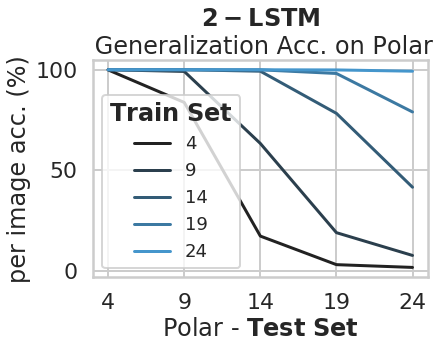

In [15]:

dataset_labels = ['4','9','14','19','24']
#fontbf = FontProperties()
#fontbf.set_weight('bold')

if NET == 'dilation':
    cc = itertools.cycle(sns.dark_palette((122, 90, 70), input="husl"))
    NET = "Dilated"
if NET == 'multi_lstm_init':
    cc = itertools.cycle(sns.dark_palette((240, 90, 70), input="husl"))
    NET = "2-LSTM"
if NET == 'UNet':
    cc = itertools.cycle(sns.dark_palette((5, 70, 70), input="husl"))
    NET = "UNet"
    
def plot_results_generalization(train, title, fig, name):
    x = np.linspace(1,NUM_COMPLEXITIES, NUM_COMPLEXITIES)
    xlabels = dataset_labels
    ytext = 'per image acc. (%)'
    xtext = r'Polar - $\bf Test$ $\bf Set$'
    
    plt.figure(fig)
    #print(train)
    plt.plot(x, train, label=name, color=next(cc))
    plt.title(title)
    plt.ylabel(ytext)
    plt.xticks(x, xlabels)
    plt.xlabel(xtext)
    leg = plt.legend(loc='lower left', ncol=1,  title=r'$\bf Train$ $\bf Set$', fancybox=True, prop={'size': 18})
    plt.savefig('./fig/quantitative/' + NET +'.pdf', format='pdf',  bbox_inches='tight', dpi=1000)

for res in results_data_generalization:
    
    #Collect all generalization results for one network
    test = np.zeros([2, NUM_COMPLEXITIES])
    test_loose = np.zeros([2, NUM_COMPLEXITIES])
    for idx_strict, dataset_strict_complexity  in enumerate([True, False]):
        for dataset_complexity in range(NUM_COMPLEXITIES):
            if not int(datasets_idx[idx_strict,dataset_complexity])==0:
                test[idx_strict, dataset_complexity] = \
                    res["results"]["test_accuracy"][int(datasets_idx[idx_strict,dataset_complexity])]
                test_loose[idx_strict, dataset_complexity] = \
                    res["results"]["test_accuracy_loose"][int(datasets_idx[idx_strict,dataset_complexity])]

    plot_results_generalization(100*test[0,:], r"$\bf " + NET+"$\n Generalization Acc. on Polar", 0, dataset_labels[res['dataset_complexity']])

        